In [15]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from __future__ import division
from __future__ import print_function
from __future__ import absolute_import
from __future__ import unicode_literals

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import collections

import IPython

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [34]:
data_folder = '../output-explore-infl-logreg/'
data_filenames = ['explore-infl-logreg-data-hospital-prop-0.1-subsets-5-subset_seed-13-center-data-False.npz',
                 'explore-infl-logreg-data-hospital-prop-0.1-subsets-6-subset_seed-13-center-data-False.npz',
                 'explore-infl-logreg-data-hospital-prop-0.1-subsets-30-subset_seed-13-center-data-False.npz']
data_filename = data_filenames[2]
f = np.load(os.path.join(data_folder, data_filename))
f = collections.defaultdict(lambda: None, f)

initial_train_losses = f['initial_train_losses']
initial_test_losses = f['initial_test_losses']
initial_train_margins = f['initial_train_margins']
initial_test_margins = f['initial_test_margins']
grad_loss = f['grad_loss']
test_points = f['test_points']
fixed_test_pred_infl = f['fixed_test_pred_infl']
fixed_test_pred_margin_infl = f['fixed_test_pred_margin_infl']
subset_tags = f['subset_tags']
subset_indices = f['subset_indices']
subset_train_losses = f['subset_train_losses']
subset_test_losses = f['subset_test_losses']
subset_train_margins = f['subset_train_margins']
subset_test_margins = f['subset_test_margins']
subset_self_influences = f['subset_self_pred_infl']
subset_self_pred_margin_influences = f['subset_self_pred_margin_infl']

# old naming convention
if subset_self_influences is None:
    subset_self_influences = f['subset_self_influences']
if subset_self_pred_margin_influences is None:
    subset_self_pred_margin_influences = f['subset_self_margin_influences']

unique_tags = np.unique(subset_tags)
unique_subset_colors = ['b', 'r', 'g', 'c', 'm', 'y', 'k', 'coral', 'olive', 'dodgerblue', 'pink', 'khaki', 'peru', 'indigo', 'orange', 'springgreen', 'rebeccapurple']
assert len(unique_subset_colors) >= len(unique_tags)
tag_to_color = dict(zip(unique_tags, range(len(unique_tags))))
subset_colors = [unique_subset_colors[tag_to_color[tag]] for tag in subset_tags]

In [41]:
# Plot self-influence actual vs predicted
def plot_self_infl_data(mode='loss'):
    assert mode in ['loss', 'margin']
    plt.figure(figsize=(4,4))
    W = 0
    labels = set()
    if mode == 'loss':
        init = initial_test_losses
        subset_train = subset_train_losses
        subset_self_infl = subset_self_influences
    elif mode == 'margin':
        init = initial_test_margins
        subset_train = subset_train_margins
        subset_self_infl = subset_self_pred_margin_influences
    assert init is not None and subset_train is not None and subset_self_infl is not None
    
    for subset_num, indices in enumerate(subset_indices):
        subset_initial_losses = np.sum(init[indices])
        subset_retrained_losses = np.sum(subset_train[subset_num][indices])
        subset_actl_infl = subset_retrained_losses - subset_initial_losses
        subset_pred_infl = subset_self_infl[subset_num]
        W = max(W, np.max(np.abs(subset_actl_infl)), np.max(np.abs(subset_pred_infl)))
        if subset_tags[subset_num] not in labels:
            label = subset_tags[subset_num]
            labels.add(label)
        else:
            label = None
        if mode == 'margin':
            subset_pred_infl *= -1
        plt.scatter(subset_actl_infl, subset_pred_infl, color=subset_colors[subset_num], label=label)
        W = max(W, np.max(np.abs(subset_actl_infl)), np.max(np.abs(subset_pred_infl)))

    if mode == 'loss':
        plt.plot([-W/20, W], [-W/20, W],color='grey',alpha=0.3)
    elif mode == 'margin':
        plt.plot([-W, W/20], [-W, W/20],color='grey',alpha=0.3)
    plt.title('Self-influence')
    plt.legend(loc='upper center', bbox_to_anchor=(1.45, 0.8), ncol=1)
    plt.xlabel('Actual sum of self-{} for subset'.format(mode))
    plt.ylabel('Predicted sum of self-{} for subset'.format(mode))

# Plot fixed test point actual vs predicted
def plot_test_pt_data(mode='loss'):
    assert mode in ['loss', 'margin']
    fig, axs = plt.subplots(len(test_points), 1, figsize=(4, 4 * len(test_points)), squeeze=False)

    for i, test_idx in enumerate(test_points):
        #if i > 0: break
        W = 0
        if mode == 'loss':
            init = initial_test_losses
            subset_test = subset_test_losses
            fixed_test_pred = fixed_test_pred_infl
        elif mode == 'margin':
            init = initial_test_margins
            subset_test = subset_test_margins
            fixed_test_pred = fixed_test_pred_margin_infl
        assert init is not None and subset_test is not None and fixed_test_pred is not None
        
        subset_initial_losses = np.array(init[test_idx])
        labels = set()
        for subset_num, indices in enumerate(subset_indices):
            subset_retrained_losses = np.array(subset_test[subset_num][test_idx])
            subset_actl_infl = subset_retrained_losses - subset_initial_losses
            subset_pred_infl = np.sum(fixed_test_pred[i][indices])
            if subset_tags[subset_num] not in labels:
                label = subset_tags[subset_num]
                labels.add(label)
            else:
                label = None
            if mode == 'margin':
                subset_pred_infl *= -1
            axs[i][0].scatter(subset_actl_infl, subset_pred_infl, color=subset_colors[subset_num], label=label)
            W = max(W, np.max(np.abs(subset_actl_infl)), np.max(np.abs(subset_pred_infl)))

        axs[i][0].plot([-W, W], [-W, W],color='grey',alpha=0.3)
        axs[i][0].set_title('Test_idx: {}'.format(test_idx))
        axs[i][0].legend(loc='upper center', bbox_to_anchor=(1.45, 0.8), ncol=1)
        axs[i][0].set_xlabel('Actual influence on test pt {}'.format(mode))
        axs[i][0].set_ylabel('Predicted influence on test pt {}'.format(mode))
    fig.subplots_adjust(hspace=0.2)

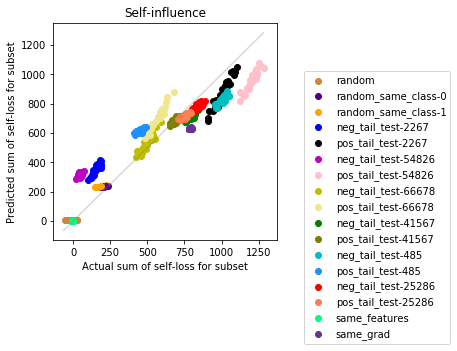

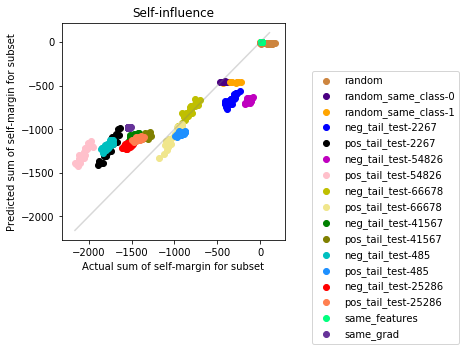

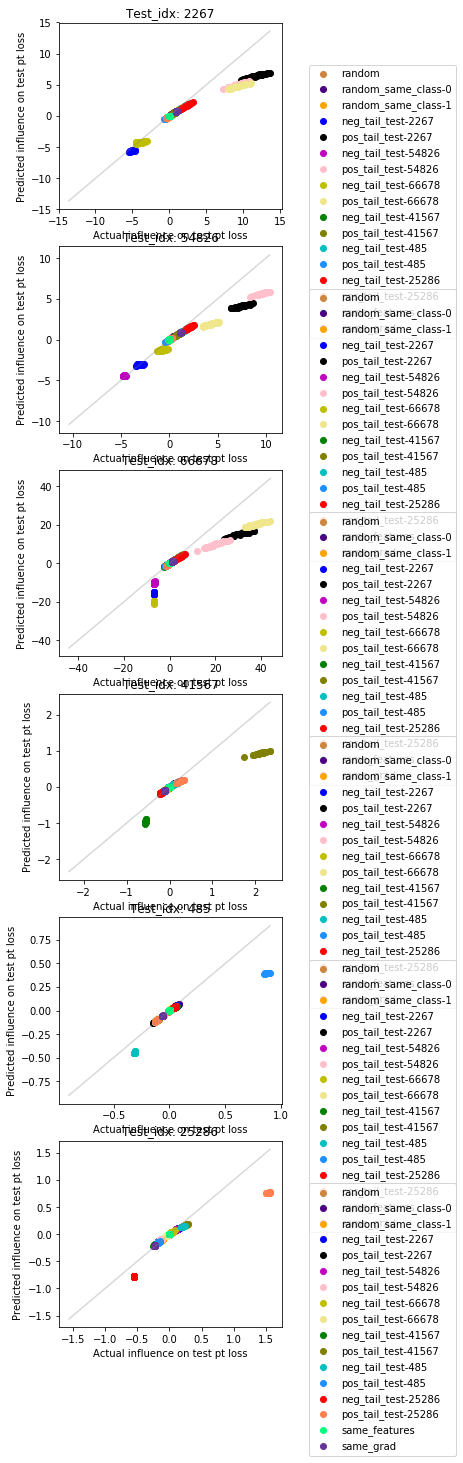

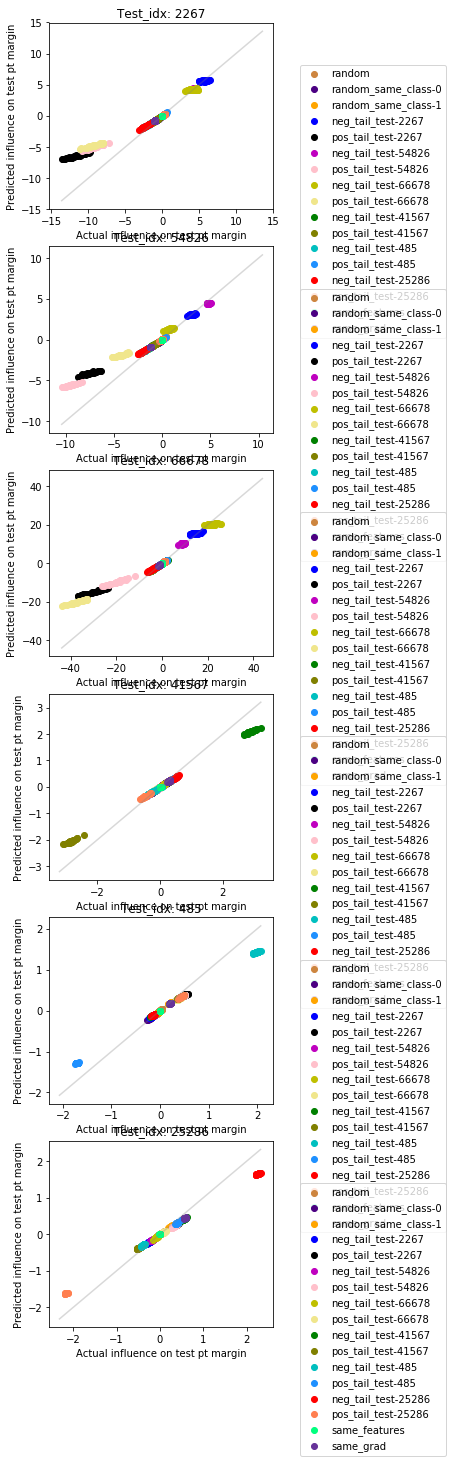

In [42]:
plot_self_infl_data()
plot_self_infl_data('margin')
plot_test_pt_data()
plot_test_pt_data('margin')

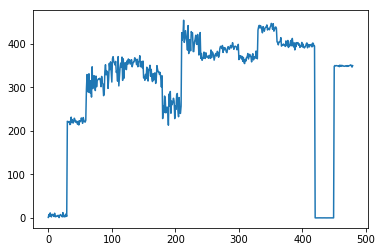

In [45]:
plt.plot(np.abs(subset_self_influences-subset_self_pred_margin_influences))